# Image classifier

## Import necessary libraries

In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil as su
import random as rd
import cv2
from scipy import ndimage
from sklearn import svm, metrics

## Load data

In [56]:
%%bash
mkdir -p tmp_data
rm -rf tmp_data/*
mkdir -p tmp_data/train_set
mkdir -p tmp_data/test_set

## Separate training dataset

In [57]:
def separate_data(path, nb_elements=1):
    """
    Separate given data in `path` in two sets with `nb_elements` per class for test

    Parameters
    ----------
    path: str
        Path to directory where dataset files are stored.

    nb_elements: integer
        Defines the number of test images taken in each class of the dataset
    """
    labels_path = os.path.join(path, "labels.txt")
    images_path = path
    test_path = 'tmp_data/test_set'
    train_path = 'tmp_data/train_set'

    
    labels = np.empty((0, 1))
    names = np.empty((0, 1))
    with open(labels_path) as f:
        for current_label in f:
            if current_label == "\n":
                continue
            label, name = current_label.split(": ")
            labels = np.append(labels, label)
            names = np.append(names, name)

    for label in labels:
        pre_label = 'img_' + label + '_'
        curr_test_path = os.path.join(test_path, label)
        curr_train_path = os.path.join(train_path, label)
        os.makedirs(curr_test_path, exist_ok=True)
        os.makedirs(curr_train_path, exist_ok=True)

        current_path = os.path.join(images_path, label)
        datas = os.listdir(current_path)
        rd.shuffle(datas)

        count = 0
        for data in datas:
            data_path = os.path.join(current_path, data)
            if count < nb_elements:
                su.copyfile(data_path, os.path.join(curr_test_path, pre_label + str(count) + '.png'))
            else:
                su.copyfile(data_path, os.path.join(curr_train_path, pre_label + str(count - nb_elements) + '.png'))
            count += 1

    return labels, names

In [58]:
ref = separate_data('ressources/train', 2)

## Get separated datasets

In [59]:
def get_datasets(kind='train'):
    """
    Returns `kind` set and their label

    Parameters
    ----------
    kind: str (train or test)
        Type of dataset we want to get
    """
    assert kind == 'train' or kind == 'test'
    dataset_path = 'tmp_data/train_set' if kind == 'train' else 'tmp_data/test_set'
    
    images = []
    labels = []
    dirs = os.listdir(dataset_path)

    for folder in dirs: 
        curr_path = os.path.join(dataset_path, folder)
        datas = os.listdir(curr_path)
        for data in datas:
            data_path = os.path.join(curr_path, data)
            img = cv2.imread(data_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(folder)
    
    return labels, images

In [60]:
train_labels, train_images = get_datasets('train')
test_labels, test_images = get_datasets('test')

## Augment datasets

In [61]:
def augment_datasets(labels, images, nb=10):
    new_labels = []
    new_images = []
    original_size = len(labels)
    mat = [False for _ in range(original_size)]
    index = np.random.randint(original_size)
    for _ in range(nb):
        if not False in mat:
            mat = [False for _ in range(original_size)]
        while mat[index] == True:
            index = np.random.randint(original_size)
        mat[index] = True
        img = ndimage.rotate(images[index], np.random.rand() * 360, cval=255)
        new_labels.append(labels[index])
        new_images.append(img)
    return np.array(new_labels), np.array(new_images)

In [62]:
print(len(train_images))
train_labels, train_images = augment_datasets(train_labels, train_images, 2000)
print(len(train_images))

171
1000


C:\Users\nuki\AppData\Local\Temp/ipykernel_30076/1989293365.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_labels), np.array(new_images)


## Shuffle datasets

In [63]:
def shuffle_set(labels, images):
    """
    Shuffles equally labels and images

    Parameters
    ----------
    labels: [str]
        Dataset's labels
        
    images: [image]
        Dataset's images
    """
    assert len(labels) == len(images)
    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)
    new_labels = np.array(labels)
    new_images = np.array(images, dtype=object)
    
    for ii in range(shuffle_index.size):
        new_labels[ii] = labels[shuffle_index[ii]]
        new_images[ii] = images[shuffle_index[ii]]
        
    return new_labels, new_images   

In [64]:
train_labels, train_images = shuffle_set(train_labels, train_images)
test_labels, test_images = shuffle_set(test_labels, test_images)

## Resize images

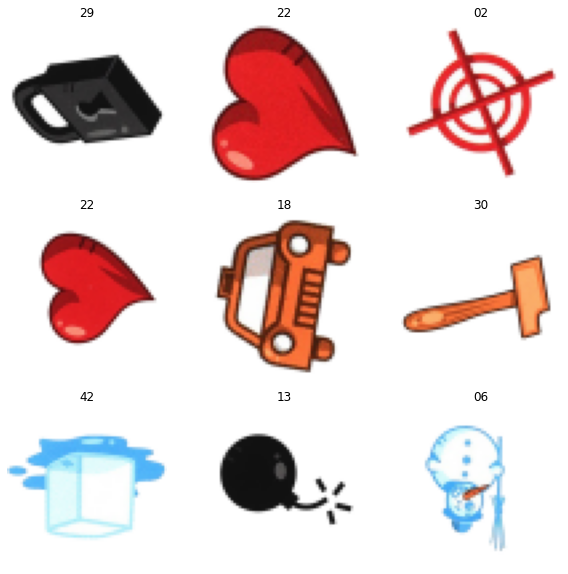

In [65]:
def image_resize(image, width, height, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    (h, w) = image.shape[:2]

    # calculate the ratio of the width and construct the
    # dimensions
    if w > h:
        r = width / float(w)
        dim = (width, int(h * r))
    else:
        r = height / float(h)
        dim = (int(w * r), height)

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    ret = np.full((height, width, 3), 255, np.uint8)
    

    y_offset = int((height - resized.shape[0]) / 2)
    x_offset = int((width - resized.shape[1]) / 2)
    ret[y_offset:y_offset+resized.shape[0], x_offset:x_offset+resized.shape[1]] = resized

    # return the resized image
    return ret

def resize_images(images):
    resized = []
    for image in images: 
        resized.append(image_resize(image, 60, 60))
    return resized

train_images_resized = np.array(resize_images(train_images))
test_images_resized = np.array(resize_images(test_images))

plt.figure(figsize=(10, 10))
for j in range(9):
    #print(train_images_resized[j].shape[:2])
    ax = plt.subplot(3, 3, j + 1)
    plt.imshow(train_images_resized[j])
    plt.title(train_labels[j])
    plt.axis("off")

C:\Users\nuki\AppData\Local\Temp/ipykernel_30076/44580148.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


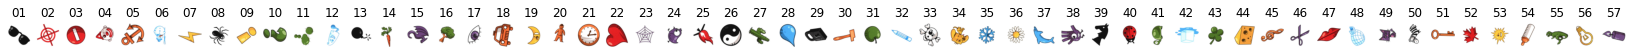

In [66]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(train_labels)
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(29,15)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    occ = np.where(train_labels == label)
    idx = occ[0][0]
     
    ax.imshow(train_images_resized[idx])
    ax.axis('off')
    ax.set_title(label)

## Display repartition

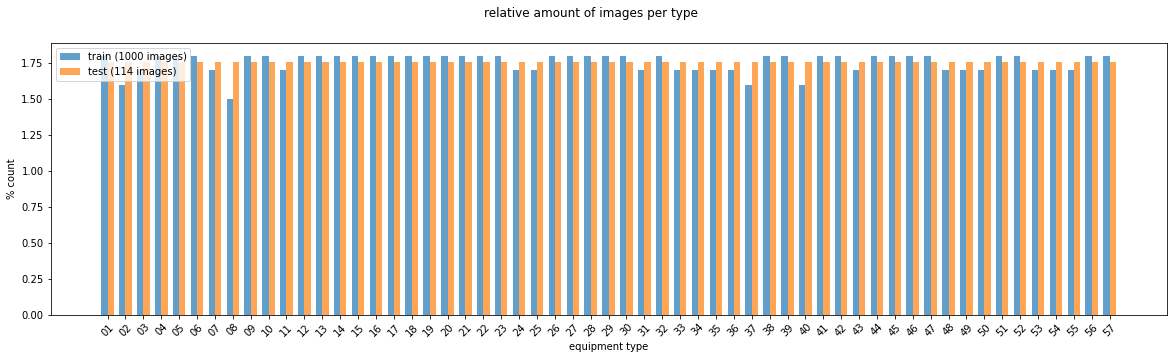

In [67]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.figure(figsize=(20, 5))
plt.suptitle('relative amount of images per type')
plot_bar(train_labels, loc='left')
plot_bar(test_labels, loc='right')
plt.legend([
    'train ({0} images)'.format(len(train_labels)), 
    'test ({0} images)'.format(len(test_labels))
]);

## Train model

In [68]:
clf = svm.SVC(gamma=0.001)

In [69]:
nsamples, nx, ny, nz = train_images_resized.shape
x_train = train_images_resized.reshape((nsamples,nx*ny*nz))
x_train = x_train / 255
clf.fit(np.array(x_train), train_labels)

SVC(gamma=0.001)

## Make prediction

In [70]:
nsamples, nx, ny, nz = test_images_resized.shape
x_test = test_images_resized.reshape((nsamples,nx*ny*nz))
x_test = x_test / 255
predicted = clf.predict(x_test)

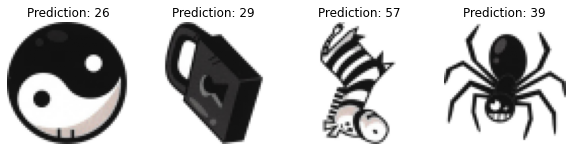

In [71]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, x_test, predicted):
    ax.set_axis_off()
    image = image.reshape(60, 60, 3)
    ax.imshow(image)
    ax.set_title(f"Prediction: {prediction}")

In [72]:
acc = (predicted == test_labels).sum()
print(acc / len(predicted))

0.5877192982456141


In [73]:
for i in range(len(test_labels)):
    if predicted[i] != test_labels[i]:
        print(predicted[i], test_labels[i])
        

57 50
39 08
31 43
52 40
20 36
39 16
49 57
18 34
27 55
52 22
39 29
50 14
44 53
50 33
49 17
50 14
10 27
05 34
50 46
45 36
10 18
26 31
50 57
12 42
20 45
42 48
32 12
26 24
05 11
39 13
05 02
05 04
39 08
44 53
12 06
50 33
56 11
05 04
42 48
04 05
51 30
47 20
46 45
05 02
41 55
49 17
47 25
